In [9]:
import pandas as pd
import matplotlib.pyplot as plt

import string
import re

import nltk
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem import PorterStemmer
import seaborn as sns
sns.set(color_codes=True)

from pyecharts.charts import WordCloud
from collections import Counter

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ShuyiChen/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Raw Data Basics

In [3]:
lyrics = pd.read_csv('lyrics.csv')
data = pd.read_csv('artists.csv')


In [4]:
#the dimension of the data
lyrics.shape

(125715, 5)

In [5]:
#check missing values
lyrics.isna().sum()

song      0
year      0
artist    0
genre     0
lyrics    0
dtype: int64

In [6]:
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125715 entries, 0 to 125714
Data columns (total 5 columns):
song      125715 non-null object
year      125715 non-null int64
artist    125715 non-null object
genre     125715 non-null object
lyrics    125715 non-null object
dtypes: int64(1), object(4)
memory usage: 4.8+ MB


## Text Processing

In [10]:
stop_words = set(['lot','today','months','month','wanna','wouldnt','wasnt','ha','na','ooh','da','gonna','im','dont','aint','wont','yeah','la','oi','nigga','fuck','hey','year','years','last','past','feel']+nltk.corpus.stopwords.words('english'))

In [11]:
genres =  lyrics.genre.value_counts().index
genres

Index(['Rock', 'Pop', 'Metal', 'Hip-Hop', 'Country', 'Jazz', 'Not Available',
       'Electronic', 'R&B', 'Indie', 'Folk', 'Other'],
      dtype='object')

In [12]:
ps = PorterStemmer()

In [13]:
def clean(text):
    text =  re.sub("[%s]"%string.punctuation,"",text).lower()
    words = text.split()
    return[ps.stem(word) for word in words if word not in stop_words and len(word)>0]
lyrics['lyrics_clean'] = lyrics.lyrics.apply(clean)

# Data Visualizations
## Count the number of songs on each year and visualize in a chart

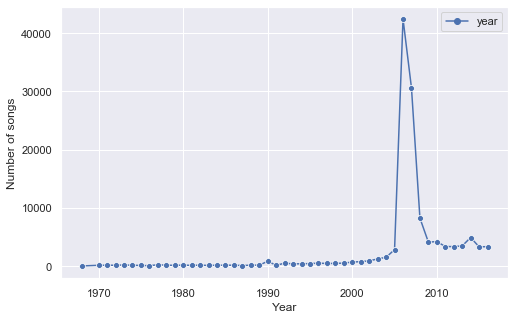

In [17]:

song_counts = pd.DataFrame(lyrics.year.value_counts().sort_index(ascending=False).iloc[:-2])
plt.figure(figsize=(8,5))
sns.lineplot(data = song_counts,markers = True, dashes = False,)
plt.xlabel("Year")
plt.ylabel("Number of songs")
plt.show()

## calculate the proportion of each genres in each year and visualize in a chart

In [21]:

genre_propotion = lyrics.groupby("year")["genre"].value_counts()/lyrics.groupby('year').size()
genre_propotion = genre_propotion.reset_index().rename({0:"propotion"},axis = 1)
genre_propotion = genre_propotion[genre_propotion.year >= 2000]

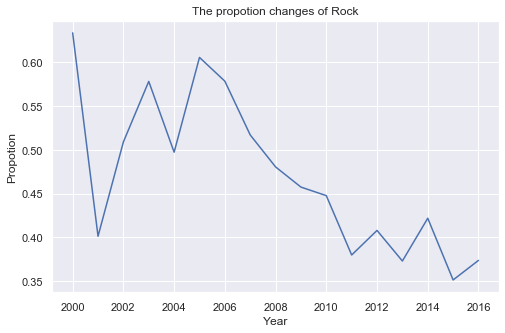

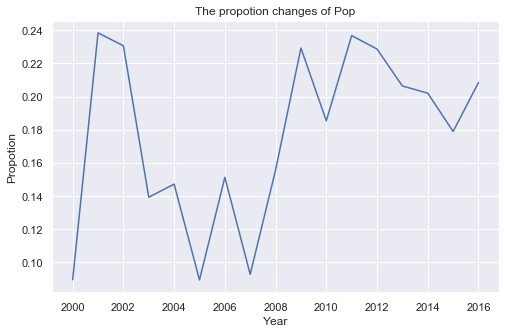

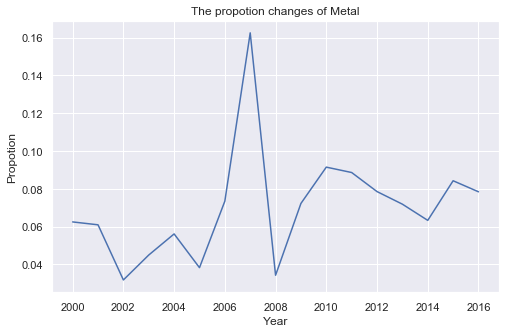

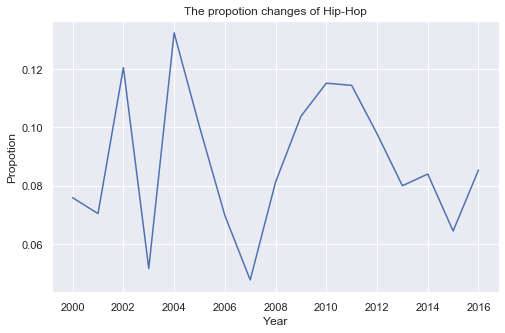

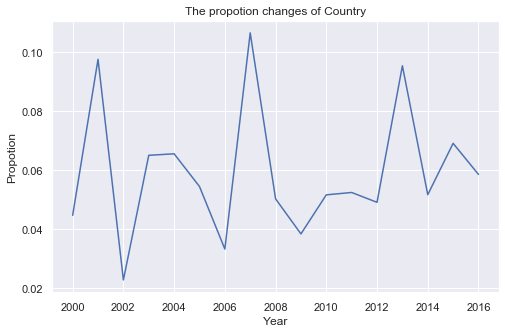

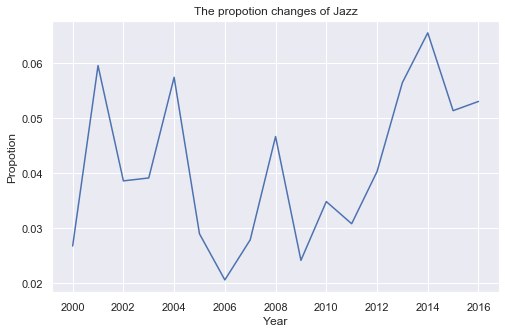

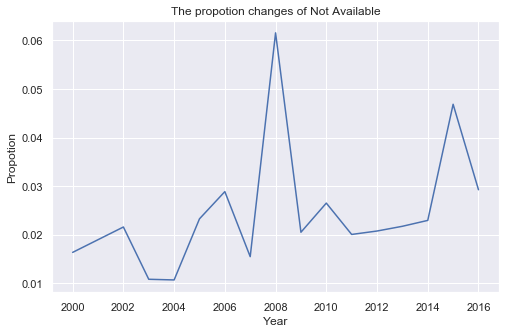

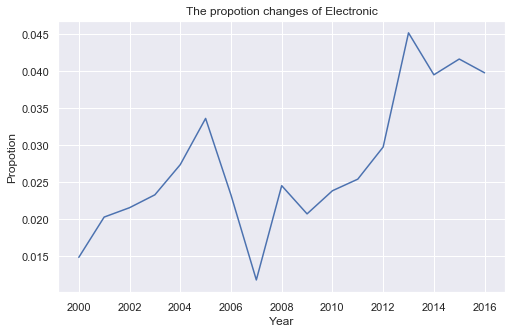

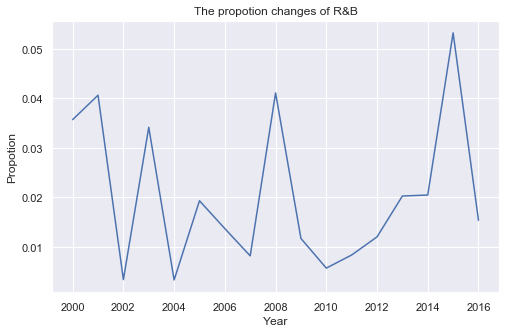

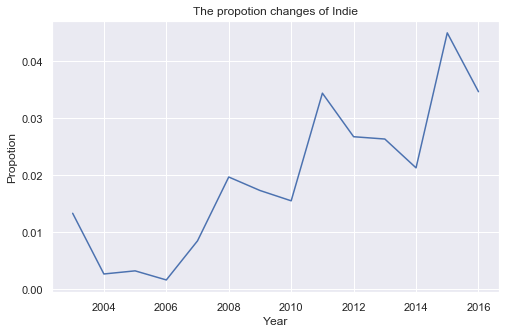

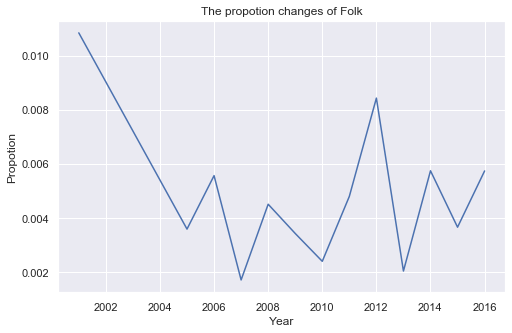

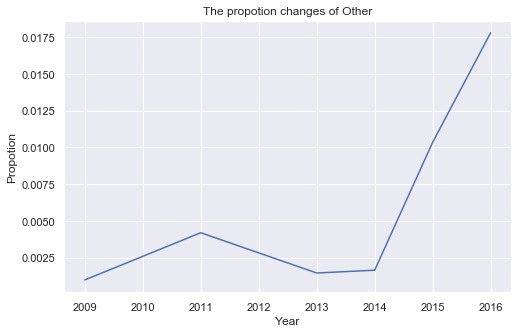

In [27]:
for genre in genres:
    df = genre_propotion[genre_propotion.genre == genre]
    plt.figure(figsize = (8,5))
    plt.title("The propotion changes of %s"%genre)
    sns.lineplot(x=df.year,y= df.propotion, markers = True,dashes = False,)
    plt.xlabel("Year")
    plt.ylabel("Propotion")
    plt.show()

In [28]:
song = lyrics[(lyrics.year == 2008)|(lyrics.year == 2009)].copy()

# Apply Topic model

In [36]:
lyrics["lyrics_clean_join"] = lyrics.lyrics_clean.apply(lambda x: ' '.join(x))

In [37]:
#number of features
n_features = 200
#number of toppics
n_topics = 5

In [48]:
tf_vectorizer = CountVectorizer(max_df = 0.95, min_df = 100,
                               max_features = n_features,
                               stop_words = 'english')
tf = tf_vectorizer.fit_transform(lyrics.lyrics_clean_join)

In [45]:
lda = LatentDirichletAllocation(n_components = n_topics,
                                max_iter = 10,
                                learning_method = "batch")
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [46]:
tf_feature_names = tf_vectorizer.get_feature_names()

In [47]:
for topic_idx, topic in enumerate(lda.components_):
    print("Topic #%d:" %topic_idx)
    print(" ".join([tf_feature_names[i] for i in topic.argsort()[:-10 -1:-1]]))

Topic #0:
love time know ive way say need thing tri think
Topic #1:
like got know want caus make come ya let gotta
Topic #2:
want heart ill night eye come live life away light
Topic #3:
oh love babi let know come make want ye good
Topic #4:
man girl littl look home like boy come old run


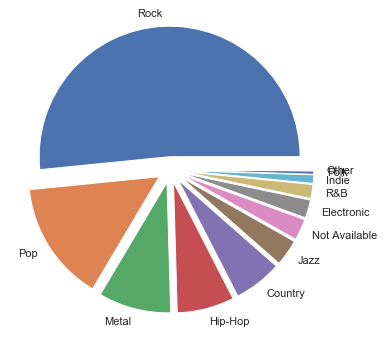

In [49]:
counts = lyrics.genre.value_counts()
plt.figure(figsize = (6,6))
pie = plt.pie(counts,labels = counts.index,explode = [0.1 for i in range(len(counts))])
plt.show()

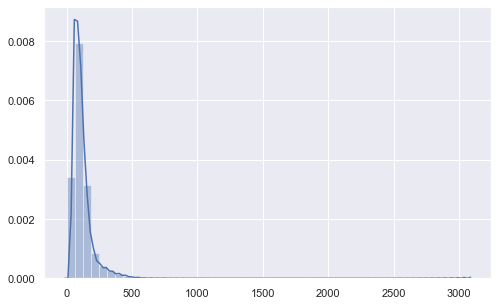

In [50]:
plt. figure(figsize = (8,5))
word_length = lyrics.lyrics_clean.apply(lambda x: len(x))
sns.distplot(word_length.values, kde = True)
plt.show()

In [52]:
n = 10
artist_counts = lyrics.artist.value_counts().sort_values().iloc[-n:]

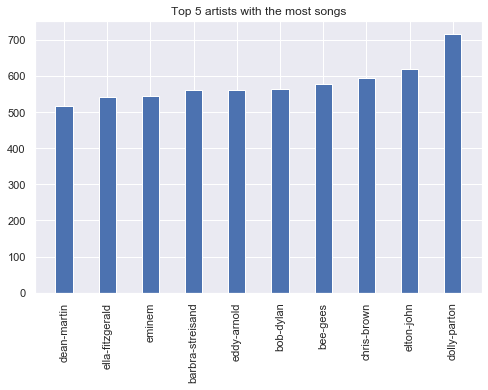

In [54]:
plt.figure(figsize=(8,5))
plt.title("Top 5 artists with the most songs")
plt.bar(artist_counts.index,artist_counts.values,width = 0.4)
plt.xticks(rotation = 90)
plt.show()

In [55]:
year_2006 = lyrics[lyrics.year == 2006].copy()

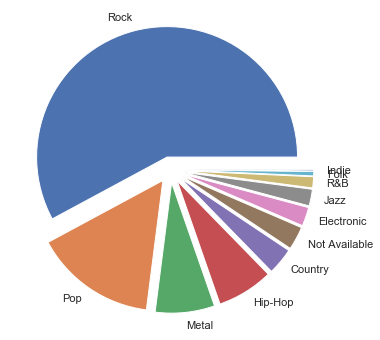

In [56]:
counts = year_2006.genre.value_counts()
plt.figure(figsize = (6,6))
pie = plt.pie(counts,labels = counts.index,explode = [0.1 for i in range(len(counts ))])

In [70]:
def get_word_cloud(genre, th = 1000):
    song_in_genre = song[song.genre == genre].lyrics_clean
    words = []
    for v in song_in_genre.values:
        words.extend(v)
    words = Counter(words)
    words = pd.Series(words)
    words = words[words > th]
    
    wordcloud = WordCloud()
    wordcloud.add('',words.index,words.values,word_size_range = [20,100],shape = 'circle')
    return wordcloud
    

In [71]:
genres

Index(['Rock', 'Pop', 'Metal', 'Hip-Hop', 'Country', 'Jazz', 'Not Available',
       'Electronic', 'R&B', 'Indie', 'Folk', 'Other'],
      dtype='object')

In [73]:
wordcloud = get_word_cloud("Pop")
wordcloud

TypeError: add() takes 3 positional arguments but 4 positional arguments (and 2 keyword-only arguments) were given